In [ ]:
# default_exp engine.gmm_loss

In [ ]:
%load_ext autoreload
%autoreload 2

# Loss function

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution
from torch.distributions.utils import _sum_rightmost
from einops import rearrange

In [ ]:
#export
def ext_log_prob(mix, x):
    
    x = mix._pad(x)
    log_prob_x = mix.component_distribution.base_dist.log_prob(x) 
    log_prob_x = _sum_rightmost(log_prob_x, 1)
    
    log_mix_prob = torch.log_softmax(mix.mixture_distribution.logits, dim=-1)  
    return log_prob_x, log_mix_prob

In [ ]:
#export
class PointProcessGaussian(Distribution):
    def __init__(self, logits, xyzi_mu, xyzi_sigma, int_logits=None, **kwargs):
        """ Defines our loss function. Given logits, xyzi_mu and xyzi_sigma 
        
        The count loss first constructs a Gaussian approximation to the predicted number of emitters by summing the mean and the variance of the Bernoulli detection probability map,
        and then maximizes the probability of the true number of emitters under this distribution. 
        The localization loss models the distribution of sub-pixel localizations with a coordinate-wise independent Gaussian probability distribution  with a 3D standard deviation. 
        For imprecise localizations, this probability is maximized for large sigmas, for precise localizations for small sigmas. 
        The distribution of all localizations over the entire image is approximated as a weighted average of individual localization distributions, where the weights correspond to the probability of detection.
        
        Args:
            logits: shape (B,1,D,H,W)
            xyzi_mu: shape (B,4,D,H,W)
            xyzi_sigma: shape (B,4,D,H,W)
        """
        self.logits = logits
        self.xyzi_mu = xyzi_mu
        self.xyzi_sigma = xyzi_sigma
        self.int_logits = int_logits
        
    def log_prob(self, locations, x_offset, y_offset, z_offset, intensities, n_bits, channels, min_int_sig, int_fac=1):
        
        gauss_dim = 3 + channels
        batch_size = self.logits.shape[0]
        if channels == 1:
            xyzi, s_mask = get_true_labels(batch_size, locations, x_offset, y_offset, z_offset, intensities)
        else:
            xyzi, s_mask = get_true_labels_mf(batch_size, n_bits, channels, 
                                              locations, x_offset, y_offset, z_offset, intensities)
        counts = s_mask.sum(-1)

        P = torch.sigmoid(self.logits) 
        count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
        count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
        count_dist = D.Normal(count_mean, torch.sqrt(count_var))

        count_prob =  count_dist.log_prob(counts) # * counts

        pix_inds = torch.nonzero(P,as_tuple=True)

        xyzi_mu = self.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
        xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
        xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
        xyzi_sig = self.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)

        
        int_P = torch.sigmoid(self.int_logits)[:,:channels]

        int_mean = int_P.sum(dim=[1])
        int_var = (int_P - int_P ** 2).sum(dim=[1])
        int_dist = D.Normal(int_mean, torch.sqrt(int_var))

        int_count_prob = (P[:,0].detach() * int_dist.log_prob(torch.ones_like(int_mean).cuda() * n_bits)).sum(dim=[1,2,3])

        mix_logits = self.logits[pix_inds].reshape(batch_size,-1)
        int_logits = rearrange(self.int_logits[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]], '(b p) ch -> b p ch', b=batch_size)

        '''split int 2'''
        xyz_sl = np.s_[:,:,:3]
        int_sl = np.s_[:,:,3:3+channels]

        comp_xyz = D.Independent(D.Normal(xyzi_mu[xyz_sl], xyzi_sig[xyz_sl] + 0.00001), 1)
        comp_int = D.Independent(D.Normal(xyzi_mu[int_sl], xyzi_sig[int_sl] + min_int_sig), 1)

        xyz = xyzi[xyz_sl].transpose(0, 1)[:,:,None,:]
        log_prob_xyz = comp_xyz.base_dist.log_prob(xyz) 
        log_prob_xyz = _sum_rightmost(log_prob_xyz, 1)

        log_mix_prob_xyz = torch.log_softmax(mix_logits, -1)

        ''' '''
        int_ch = xyzi[int_sl].transpose(0, 1)[:,:,None,:]
        int_bin = torch.where(int_ch > 0, torch.ones_like(int_ch), torch.zeros_like(int_ch))
        log_prob_int = comp_int.base_dist.log_prob(int_ch)

        log_mix_prob_int = torch.log_softmax(int_logits, dim=-1) + torch.log(4*torch.ones(1)).cuda()

        total_prob_int = torch.logsumexp(torch.gather((log_prob_int + log_mix_prob_int), -1, int_bin.argsort(-1, descending=True).expand(-1,-1,log_prob_int.shape[2],-1))[...,:4] ,-1)
        total_prob_xyz = torch.logsumexp(log_prob_xyz + log_mix_prob_xyz + total_prob_int,-1).transpose(0, 1)
        
#         total_prob_xyz = torch.logsumexp(log_prob_xyz + log_mix_prob_xyz + _sum_rightmost(log_prob_int, 1),-1).transpose(0, 1) # old loss new format

        total_prob = ((total_prob_xyz) * s_mask).sum(-1)

        return count_prob + 0.0*int_count_prob, total_prob
    
    def log_prob_old(self, locations, x_offset, y_offset, z_offset, intensities, n_bits, channels, min_int_sig, int_fac=1):
        """ Creates the distributions for the count and localization loss and evaluates the log probability for the given set of localizations under those distriubtions.
        
            Args:
                locations: tuple with voxel locations of inferred emitters
                x_offset, y_offset,z_offset: continuous within pixel offsets. Has lenght of number of emitters in the whole batch.
                intensties: brightness of emitters. Has lenght of number of emitters in the whole batch.
                
            Returns:
                count_prob: count loss. Has langth of batch_size
                spatial_prob: localizations loss. Has langth of batch_size
        """     
        
        gauss_dim = 3 + channels
        batch_size = self.logits.shape[0]
        if channels == 1:
            xyzi, s_mask = get_true_labels(batch_size, locations, x_offset, y_offset, z_offset, intensities)
        else:
            xyzi, s_mask = get_true_labels_mf(batch_size, n_bits, channels, 
                                              locations, x_offset, y_offset, z_offset, intensities)
        counts = s_mask.sum(-1)
        
        P = torch.sigmoid(self.logits) 
        count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
        count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
        count_dist = D.Normal(count_mean, torch.sqrt(count_var))
                
        count_prob =  count_dist.log_prob(counts) # * counts
        
        mixture_probs = P / P.sum(dim=[2, 3, 4], keepdim=True)
        
        pix_inds = torch.nonzero(P,as_tuple=True)

        xyzi_mu = self.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
        xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
        xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
        xyzi_sig = self.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)

#         print(xyzi_mu.shape, xyzi.shape)
        
        mix = D.Categorical(mixture_probs[pix_inds].reshape(batch_size,-1))
        
        '''base 19 dim'''
#         xyzi_sig[:,:,3:] = xyzi_sig[:,:,3:] + min_int_sig
#         comp = D.Independent(D.Normal(xyzi_mu, xyzi_sig + 0.00001), 1)
#         spatial_gmm = D.MixtureSameFamily(mix, comp)
#         spatial_prob = spatial_gmm.log_prob(xyzi.transpose(0, 1)).transpose(0,1)
#         total_prob = (spatial_prob * s_mask).sum(-1)
        '''split int'''
        xyz_sl = np.s_[:,:,:3]
        int_sl = np.s_[:,:,3:]
        
        xyzi_sig[int_sl] = xyzi_sig[int_sl] + min_int_sig
        
        comp_xyz = D.Independent(D.Normal(xyzi_mu[xyz_sl], xyzi_sig[xyz_sl] + 0.00001), 1)
        comp_int = D.Independent(D.Normal(xyzi_mu[int_sl], xyzi_sig[int_sl] + 0.00001), 1)
        
        spatial_gmm = D.MixtureSameFamily(mix, comp_xyz)
        int_gmm = D.MixtureSameFamily(mix, comp_int)
        
        spatial_prob, log_mix_prob = ext_log_prob(spatial_gmm, xyzi[xyz_sl].transpose(0, 1))
        int_prob, _                = ext_log_prob(int_gmm, xyzi[int_sl].transpose(0, 1))

        total_prob = torch.logsumexp(spatial_prob + 0*int_prob + log_mix_prob,-1).transpose(0, 1)
        total_prob = (total_prob * s_mask).sum(-1)
        
        return count_prob, total_prob

def get_sample_mask(bs, locations):
    
    counts_ = torch.unique(locations[0], return_counts=True)[1]
    batch_loc = torch.unique(locations[0])
    
    counts = torch.cuda.LongTensor(bs).fill_(0)
    counts[batch_loc] = counts_
    
    max_counts = counts.max()
    if max_counts==0: max_counts = 1 #if all 0 will return empty matrix of correct size
    s_arr = cum_count_per_group(locations[0])
    s_mask   = torch.cuda.FloatTensor(bs,max_counts).fill_(0)
    s_mask[locations[0],s_arr] = 1   
    
    return s_mask, s_arr
    
def get_true_labels(bs, locations, x_os, y_os, z_os, *args):
    
    s_mask, s_arr = get_sample_mask(bs, locations)
    max_counts = s_mask.shape[1]
    
    x =  x_os + locations[4].type(torch.cuda.FloatTensor) + 0.5 
    y =  y_os + locations[3].type(torch.cuda.FloatTensor) + 0.5 
    z =  z_os + locations[2].type(torch.cuda.FloatTensor) + 0.5 
    
    gt_vars = torch.stack([x, y, z] + [item for item in args], dim=1)
    gt_list = torch.cuda.FloatTensor(bs,max_counts,gt_vars.shape[1]).fill_(0)
    
    gt_list[locations[0],s_arr] = gt_vars
    return gt_list, s_mask    

def get_true_labels_mf(bs, n_bits, channels, locations, x_os, y_os, z_os, int_ch):
    
    b_inds = torch.cat([torch.tensor([0], device=x_os.device),((x_os[1:] - x_os[:-1]).nonzero() + 1)[:,0], 
                        torch.tensor([len(x_os)], device=x_os.device)])
    n_gt = len(b_inds) - 1
    
    xyz_locs = [l[b_inds[:-1]] for l in locations]
    x_os = x_os[b_inds[:-1]]
    y_os = y_os[b_inds[:-1]]
    z_os = z_os[b_inds[:-1]]
    
    s_mask, s_arr = get_sample_mask(bs, xyz_locs)
    max_counts = s_mask.shape[1]
    
    x =  x_os + xyz_locs[4].type(torch.cuda.FloatTensor) + 0.5 
    y =  y_os + xyz_locs[3].type(torch.cuda.FloatTensor) + 0.5 
    z =  z_os + xyz_locs[2].type(torch.cuda.FloatTensor) + 0.5 
    
    loc_idx = []
    for i in range(n_gt):
        loc_idx += [i] * (b_inds[i+1] - b_inds[i])
    
    intensity = torch.zeros([n_gt, channels]).to(x.device)
    intensity[loc_idx, locations[1]] = int_ch
    
    gt_vars = torch.stack([x, y, z], dim=1)
    gt_vars = torch.cat([gt_vars, intensity], dim=1)
    gt_list = torch.cuda.FloatTensor(bs,max_counts,gt_vars.shape[1]).fill_(0)
    
    gt_list[xyz_locs[0],s_arr] = gt_vars
    return gt_list, s_mask  

def grp_range(counts: torch.Tensor):
    assert counts.dim() == 1

    idx = counts.cumsum(0)
    id_arr = torch.ones(idx[-1], dtype=int, device=counts.device)
    id_arr[0] = 0
    id_arr[idx[:-1]] = -counts[:-1] + 1
    return id_arr.cumsum(0)

def cum_count_per_group(arr):
    """
    Helper function that returns the cumulative sum per group.
    Example:
        [0, 0, 0, 1, 2, 2, 0] --> [0, 1, 2, 0, 0, 1, 3]
    """

    if arr.numel() == 0:
        return arr

    _, cnt = torch.unique(arr, return_counts=True)
    return grp_range(cnt)[np.argsort(np.argsort(arr.cpu().numpy(), kind='mergesort'), kind='mergesort')]

In [ ]:
model_out = torch.load('../data/model_batch_output_code_int_p.pt')
sim_vars = torch.load('../data/sim_var_code_int_p.pt')

In [ ]:
ppg = PointProcessGaussian(**model_out)
ppg.log_prob(*sim_vars[:5], n_bits=4, channels=16, min_int_sig=1.)

tensor(-1864515.7500, device='cuda:0')


(tensor([-0.4427, -0.6439,  0.8149,  1.5036,  1.7690,  1.2149, -1.6208],
        device='cuda:0'),
 tensor([  0.0000, -10.8937,   0.0000,  -1.5160,  -1.5397,   0.0000,   0.0000],
        device='cuda:0'))

In [ ]:
ppg.log_prob(*sim_vars[:5], n_bits=4, channels=16, min_int_sig=-.1)

tensor(-4242107.5000, device='cuda:0')


(tensor([-0.4427, -0.6439,  0.8149,  1.5036,  1.7690,  1.2149, -1.6208],
        device='cuda:0'),
 tensor([ 0.0000, -9.4015,  0.0000, -1.1146, -1.3592,  0.0000,  0.0000],
        device='cuda:0'))

In [ ]:
locations, x_offset, y_offset, z_offset, intensities = sim_vars[:5]
n_bits=4; channels=16; min_int_sig=1.; int_fac=16

In [ ]:
gauss_dim = 3 + channels
batch_size = ppg.logits.shape[0]
if channels == 1:
    xyzi, s_mask = get_true_labels(batch_size, locations, x_offset, y_offset, z_offset, intensities)
else:
    xyzi, s_mask = get_true_labels_mf(batch_size, n_bits, channels, 
                                      locations, x_offset, y_offset, z_offset, intensities)
counts = s_mask.sum(-1)

P = torch.sigmoid(ppg.logits) 
count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
count_dist = D.Normal(count_mean, torch.sqrt(count_var))

count_prob =  count_dist.log_prob(counts) # * counts

pix_inds = torch.nonzero(P,as_tuple=True)

xyzi_mu = ppg.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
xyzi_sig = ppg.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)

mix_logits = ppg.logits[pix_inds].reshape(batch_size,-1)

int_P = torch.sigmoid(ppg.int_logits)[:,:channels]

int_mean = int_P.sum(dim=[1])
int_var = (int_P - int_P ** 2).sum(dim=[1])
int_dist = D.Normal(int_mean, torch.sqrt(int_var))

int_count_prob = (P[:,0].detach() * int_dist.log_prob(torch.ones_like(int_mean).cuda() * n_bits)).sum(dim=[1,2,3])

int_logits = rearrange(ppg.int_logits[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]], '(b p) ch -> b p ch', b=batch_size)

'''split int 2'''
xyz_sl = np.s_[:,:,:3]
int_sl = np.s_[:,:,3:3+channels]

comp_xyz = D.Independent(D.Normal(xyzi_mu[xyz_sl], xyzi_sig[xyz_sl] + 0.00001), 1)
comp_int = D.Independent(D.Normal(xyzi_mu[int_sl], xyzi_sig[int_sl] + 0.5), 1)

xyz = xyzi[xyz_sl].transpose(0, 1)[:,:,None,:]
log_prob_xyz = comp_xyz.base_dist.log_prob(xyz) 
log_prob_xyz = _sum_rightmost(log_prob_xyz, 1)

log_mix_prob_xyz = torch.log_softmax(mix_logits, -1)

''' '''
int_ch = xyzi[int_sl].transpose(0, 1)[:,:,None,:]
int_bin = torch.where(int_ch > 0, torch.ones_like(int_ch), torch.zeros_like(int_ch))
log_prob_int = comp_int.base_dist.log_prob(int_ch)

log_mix_prob_int = torch.log_softmax(int_logits, dim=-1) + torch.log(4*torch.ones(1)).cuda()

total_prob_int = torch.logsumexp(torch.gather((log_prob_int + log_mix_prob_int), -1, int_bin.argsort(-1, descending=True).expand(-1,-1,log_prob_int.shape[2],-1))[...,:4] ,-1)
total_prob_xyz = torch.logsumexp(log_prob_xyz + total_prob_int + log_mix_prob_xyz,-1).transpose(0, 1)
    
total_prob = ((total_prob_xyz) * s_mask).sum(-1)

total_prob_int

In [ ]:
torch.gather(int_ch, -1, int_bin.argsort(-1, descending=True))[...,:4]

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000]],

         [[2.2004, 3.3153, 3.5250, 3.0570]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[5.2921, 2.1371, 4.3546, 4.3649]],

         [[5.3260, 5.9417, 2.6763, 1.4460]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000]],

         [[3.8238, 5.2879, 3.3923, 4.3409]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000]],

         [[3.8967, 4.2183, 3.4798, 4.0483]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000]]]], device='cuda:0')

In [ ]:
int_bin.expand(-1,-,1)

torch.Size([3, 7, 1, 16])

In [ ]:
bla.sum()

tensor(-3239441., device='cuda:0')

In [ ]:
tra.sum()

tensor(-168510.2344, device='cuda:0')

In [ ]:
torch.gather(tra, -1, int_bin.argsort(-1, descending=True))[...,:4]

tensor(-351.2671, device='cuda:0')

In [ ]:
log_prob_int.sort(-1).values - torch.gather(log_prob_int, -1, log_prob_int.argsort(-1)) 

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [ ]:
int_inds.as_tuple

AttributeError: 'Tensor' object has no attribute 'as_tuple'

In [ ]:
int_inds = int_bin.nonzero(as_tuple=True)

In [ ]:
int_bin

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]],

         [[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
comp_int.base_dist.log_prob(int_ch)[int_bin.nonzero(as_tuple=True)].shape

torch.Size([20])

In [ ]:
log_mix_prob_int.shape

torch.Size([7, 2304, 16])

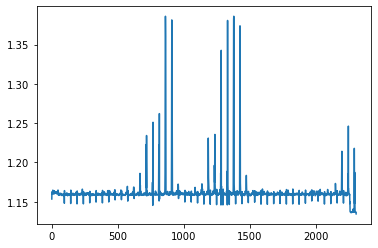

In [ ]:
plt.plot(total_prob_int[0,1].cpu())

In [ ]:
log_prob_xyz.shape

torch.Size([3, 7, 2304])

In [ ]:
int_count_prob

tensor([-1.3205, -6.7991, -0.3170, -1.9641, -2.3155, -0.1513, -5.6953],
       device='cuda:0')

In [ ]:
torch.exp(log_mix_prob_xyz.max())

tensor(1.0000, device='cuda:0')

In [ ]:
torch.exp(log_mix_prob_int_x_p).sum(-1).max()

tensor(4.0000, device='cuda:0')

In [ ]:
mixture_probs = P #/ P.sum(dim=[2, 3, 4], keepdim=True)
mix = D.Categorical(probs=mixture_probs[pix_inds].reshape(batch_size,-1))

mix_logits = ppg.logits[pix_inds].reshape(batch_size,-1)

mix_logits = mix.logits

In [ ]:
torch.sigmoid(mix.logits).sum(-1)

tensor([0.7046, 0.7743, 0.9607, 0.5040, 0.5034, 0.9645, 0.8619],
       device='cuda:0')

In [ ]:
torch.sigmoid(torch.logit(mixture_probs.reshape(7,-1))).sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

In [ ]:
mixture_probs.reshape(7,-1).sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

In [ ]:
mix.probs.sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

In [ ]:
torch.sigmoid(mix.logits).sum(-1)

tensor([0.7046, 0.7743, 0.9607, 0.5040, 0.5034, 0.9645, 0.8619],
       device='cuda:0')

In [ ]:
torch.exp(spatial_gmm.mixture_distribution.logits + torch.log(torch.ones(1).cuda()*4)).sum(-1)

tensor([4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000],
       device='cuda:0')

In [ ]:
log_mix_prob_xyz

tensor([[ -5.5903,  -8.4780,  -9.4026,  ..., -11.3734, -10.2057,  -6.4693],
        [ -9.8069, -13.7562, -13.2726,  ..., -12.6984, -12.7982,  -9.4775],
        [ -4.3763,  -7.3635,  -6.6908,  ...,  -7.2632,  -3.1791,  -2.5495],
        ...,
        [ -7.5141, -10.9540, -11.2139,  ..., -11.7508, -12.0796,  -8.9566],
        [ -3.8025,  -6.7223,  -6.2076,  ...,  -6.1614,  -6.7067,  -4.2940],
        [ -6.5509, -10.1974, -10.3095,  ..., -13.1061,  -5.4175,  -3.8014]],
       device='cuda:0')

In [ ]:
log_mix_prob_xyz

tensor([[ -5.5903,  -8.4780,  -9.4026,  ..., -11.3734, -10.2057,  -6.4693],
        [ -9.8069, -13.7562, -13.2726,  ..., -12.6984, -12.7982,  -9.4775],
        [ -4.3763,  -7.3635,  -6.6908,  ...,  -7.2632,  -3.1791,  -2.5495],
        ...,
        [ -7.5141, -10.9540, -11.2139,  ..., -11.7508, -12.0796,  -8.9566],
        [ -3.8025,  -6.7223,  -6.2076,  ...,  -6.1614,  -6.7067,  -4.2940],
        [ -6.5509, -10.1974, -10.3095,  ..., -13.1061,  -5.4175,  -3.8014]],
       device='cuda:0')

In [ ]:
print(log_prob_xyz.shape)
print(log_mix_prob_xyz.shape)
print((log_prob_xyz + log_mix_prob_xyz).shape)
print(torch.logsumexp(log_prob_xyz + log_mix_prob_xyz,-1).shape)

torch.Size([3, 7, 2304])
torch.Size([7, 2304])
torch.Size([3, 7, 2304])
torch.Size([3, 7])


In [ ]:
print(log_prob_int.shape)
print(log_mix_prob_int_x_p.shape)
print((log_prob_int + log_mix_prob_int_x_p).shape)
print(torch.logsumexp(log_prob_int + log_mix_prob_int_x_p,-1).shape)

torch.Size([3, 7, 2304, 16])
torch.Size([7, 2304, 16])
torch.Size([3, 7, 2304, 16])
torch.Size([3, 7, 2304])


In [ ]:
total_prob_int.sum(-1)

tensor([[-30149.2031, -30149.2031, -30149.2031],
        [-36184.4805, -36311.1953, -36365.1406],
        [-24744.4707, -24744.4707, -24744.4707],
        [-33971.2578, -33420.4922, -33420.4922],
        [-34393.4453, -33823.4766, -33823.4766],
        [-23325.5508, -23325.5508, -23325.5508],
        [-31364.9023, -31364.9023, -31364.9023]], device='cuda:0')

In [ ]:
total_prob_xyz.shape

torch.Size([7, 3])

In [ ]:
total_prob_int.shape

torch.Size([7, 3, 2304])

In [ ]:
torch.logsumexp(log_prob_xyz + log_mix_prob_xyz,-1).shape

torch.Size([3, 7])

In [ ]:
torch.logsumexp(log_mix_prob_int + log_mix_prob_int_x_p,-1).shape

torch.Size([7, 2304])

In [ ]:
total_prob_int.shape

torch.Size([2304, 7])

In [ ]:
total_prob_xyz.shape

torch.Size([7, 3])

In [ ]:
total_prob

tensor([ 0.0000, -1.8633,  0.0000,  0.4107,  0.5226,  0.0000,  0.0000],
       device='cuda:0')

In [ ]:
s_mask.shape

torch.Size([7, 3])

In [ ]:
int_mix.logits.shape

torch.Size([7, 2304, 16])

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48])*.001, int_conc=1.0, sim_iters=5, channels=16, n_bits=4)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample(phasing=True)

In [ ]:
locs_3d = [l.cuda() for l in locs_3d]
# xyzi_true, s_mask = get_true_labels(2, locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())
xyzi_true, s_mask = get_true_labels_mf(2, 4, 16, locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())
print(len(locs_3d[0]))
print(s_mask)
print(s_mask.sum(-1))

1782
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [ ]:
ppg = PointProcessGaussian(**model_out)
gmm_loss = ppg.log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda(), n_bits=4, channels=16, min_int_sig=0.1)
gmm_loss

(tensor([-272.8184, -314.4428], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-48894.6641, -45920.2773], device='cuda:0', grad_fn=<SumBackward1>))

In [ ]:
ppg = PointProcessGaussian(**model_out)
gmm_loss = ppg.log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda(), n_bits=4, channels=16, min_int_sig=0.1)
gmm_loss

torch.Size([119, 2, 2304, 3])
torch.Size([119, 2, 2304, 16])


(tensor([-272.8184, -314.4428], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-48895.4141, -45920.4023], device='cuda:0', grad_fn=<SumBackward1>))

In [ ]:
gmm_loss[1]

tensor([ -6410.5063, -12788.6523], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
# for i in range(1000):
#     gmm_loss = PointProcessGaussian(**model_out).log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted index.ipynb.
